### Find Similar Restaurants in Yelp
#### Based on Restaurant Attributes and Cuisines Offered
#### Notebook Author: Nirupam

#### 1. Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import re

#### 2. Load Data

In [2]:
raw_data = pd.read_csv('../../../data/arizona_business_details.csv', skipinitialspace=True)

#### 3. Extract Attributes
Extract Attributes and transform them into one-hot-vector

In [3]:
final_df = raw_data
final_df['Attrs_yes'] = final_df['attributes'].apply(lambda x: re.findall(".?'([a-zA-Z]*)'\s*:\s*'True'", str(x)))
final_df['price_str'] = final_df['attributes'].apply(lambda x: "".join(re.findall(".?'RestaurantsPriceRange2'\s*:\s*'(.?)",str(x))))
final_df['price_rng'] = final_df['price_str'].apply(lambda x: int(x) if x else 0)

In [4]:
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(final_df['Attrs_yes']),columns=mlb.classes_, index=final_df.index)

In [5]:
result = pd.concat([final_df, df],axis=1)

#### 4. Extract Cuisines
Extract Cusisine information and transform them into one-hot-vector

In [6]:
df_cats = final_df['categories'].str.get_dummies(', ')

In [7]:
result = pd.concat([result, df_cats],axis=1)

#### 5. Check and Prepare Data

In [8]:
result.head(2)

,Unnamed: 0,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,...,Wills,Wine & Spirits,Wine Bars,Wine Tasting Room,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga,Zoos
0,8,1440 N. Dysart Ave,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",8-NRKkPY1UiFXW20WXKiXg,"Mexican, Restaurants",Avondale,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,33.448106,-112.341302,...,0,0,0,0,0,0,0,0,0,0
1,12,2801 N 15th Ave,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",_c3ixq9jYKxhLUB0czi0ug,"Bars, Sports Bars, Dive Bars, Burgers, Nightli...",Phoenix,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,33.479807,-112.091188,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Dropping unecessary columns
drop_cols = ['Unnamed: 0', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 
             'longitude', 'name', 'neighborhood', 'state', 'Attrs_yes', 'postal_code', 'price_str']
data = result.drop(columns=drop_cols)

In [10]:
data = data.set_index('business_id')

In [11]:
# Fitting all data between 0 and 1
data = data.apply(lambda x: x / np.max(x), axis=0)

#### 6. Define Similarity Functions
1. Cosine Similarity
2. Jaccard Similarity
3. Ecucledian Distance
4. Pearson Correlation

In [12]:
def cos_sim(a, b):
    """Takes 2 vectors a, b and returns the cosine similarity according 
    to the definition of the dot product
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def jaccard_sim(a, b):
    """Takes 2 vectors a, b and returns the jaccard similarity
    """
    a = np.array(a)
    b = np.array(b)
    
    aandb = np.array(list(map(lambda x, y: x * y, a, b)))
    aorb = np.add(a,b)
    
    intersection_count = (aandb > 0).sum()
    union_count = (aorb > 0).sum()
    
    if(union_count == 0):
        return 0
    
    return intersection_count / union_count

def eucledian_dist(a, b):
    """Provides the dissimilarity between two vectors
    Here we provide how many dimensions are dissimilar between both the vectors
    """
    a = np.array(a)
    b = np.array(b)
    
    aandb = np.array(list(map(lambda x, y: x * y, a, b)))
    
    a_count = (a > 0).sum()
    b_count = (b > 0).sum()
    intersection_count = (aandb > 0).sum()
    
    return (a_count + b_count - 2 * intersection_count)

def pearsonr(x, y):
    """ Takes 2 vectors x, y and returns the pearson similarity
    """
    # Assume len(x) == len(y)
    n = len(x)
    sum_x = float(sum(x))
    sum_y = float(sum(y))
    sum_x_sq = sum(map(lambda x: pow(x, 2), x))
    sum_y_sq = sum(map(lambda x: pow(x, 2), y))
    psum = sum(map(lambda x, y: x * y, x, y))
    num = psum - (sum_x * sum_y/n)
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
    if den == 0: return 0
    
    return num / den

#### 7. Define functions that find similar restaurants
Take a restaurant-id and find all those restaurants that are similar to it. Report the top 6

In [13]:
df = data
def similar_restaurants_cosine(restaurant_id, n):
    sim_score = defaultdict()
    out = []
    a = df.loc[restaurant_id]
    for biz_id, row in df.iterrows():
        sim_score[biz_id] = cos_sim(a, row)
    
    score_df = pd.DataFrame.from_dict(sim_score, orient='index').reset_index()
    score_df.columns = ['business_id','similarity']
    
    final_res = df.merge(score_df, how="inner", left_on="business_id", right_on="business_id")
    final_res.sort_values(by=['similarity'], ascending=False, inplace=True)
    
    sim_list = sorted(sim_score.items(), key=lambda kv: -kv[1])[1:n+1]
    
    for (x, y) in sim_list:
        out.append(x)
    return out, final_res.head(n)[['business_id', 'similarity', 'review_count', 'stars', 'price_rng']]

def similar_restaurants_jaccard(restaurant_id, n):
    sim_score = defaultdict()
    out = []
    a = df.loc[restaurant_id]
    for biz_id, row in df.iterrows():
        sim_score[biz_id] = jaccard_sim(a, row)
    sim_list = sorted(sim_score.items(), key=lambda kv: -kv[1])[1:n+1]
    
    for (x, y) in sim_list:
        out.append(x)
    return out

def similar_restaurants_eucledian(restaurant_id, n):
    sim_score = defaultdict()
    out = []
    a = df.loc[restaurant_id]
    for biz_id, row in df.iterrows():
        sim_score[biz_id] = eucledian_dist(a, row)
    sim_list = sorted(sim_score.items(), key=lambda kv: -kv[1], reverse=True)[1:n+1]
    
    for (x, y) in sim_list:
        out.append(x)
    return out

def similar_restaurants_pearson(restaurant_id, n):
    sim_score = defaultdict()
    out = []
    a = df.loc[restaurant_id]
    for biz_id, row in df.iterrows():
        sim_score[biz_id] = pearsonr(a, row)
    sim_list = sorted(sim_score.items(), key=lambda kv: -kv[1])[1:n+1]
    
    for (x, y) in sim_list:
        out.append(x)
    return out

#### 8. Test for a given Restaurant Id

In [14]:
b_id = 'SUhBnQdG8MWkmjM6wsnVdw'
out_cos, res_cos = similar_restaurants_cosine(b_id, 6)
out_jac = similar_restaurants_jaccard(b_id, 6)
out_euc = similar_restaurants_eucledian(b_id, 6)
out_pson = similar_restaurants_pearson(b_id, 6)

#### 9. Print and Report Similar restaurants

In [15]:
print("Cosine Similarity")
print('similar restaurants for https://www.yelp.com/biz/'+b_id+' are: \n')
for each in out_cos:
    print('https://www.yelp.com/biz/'+each)
print('\n')

print("Jaccard Similarity")
print('similar restaurants for https://www.yelp.com/biz/'+b_id+' are: \n')
for each in out_jac:
    print('https://www.yelp.com/biz/'+each)
print('\n')    

print("Eucledian Dis-Similarity (Showing the least dissimilar ones)")
print('similar restaurants for https://www.yelp.com/biz/'+b_id+' are: \n')
for each in out_euc:
    print('https://www.yelp.com/biz/'+each)
print('\n')
    
print("Pearson Similarity")
print('similar restaurants for https://www.yelp.com/biz/'+b_id+' are: \n')
for each in out_pson:
    print('https://www.yelp.com/biz/'+each)

Cosine Similarity
similar restaurants for https://www.yelp.com/biz/SUhBnQdG8MWkmjM6wsnVdw are: 

https://www.yelp.com/biz/3HrT5IcO3sd4pSBCFP4OYw
https://www.yelp.com/biz/fgm7DKVy1wuod6FTPvZqRw
https://www.yelp.com/biz/WfgupKdYx1h0mKBmOmNQ3g
https://www.yelp.com/biz/tK-PQOhZo94fonbQVXaOSg
https://www.yelp.com/biz/xftWto4IdilizsGdE07AQw
https://www.yelp.com/biz/Rvj6ryvV1Wf-27UT75soMA


Jaccard Similarity
similar restaurants for https://www.yelp.com/biz/SUhBnQdG8MWkmjM6wsnVdw are: 

https://www.yelp.com/biz/3HrT5IcO3sd4pSBCFP4OYw
https://www.yelp.com/biz/WfgupKdYx1h0mKBmOmNQ3g
https://www.yelp.com/biz/fgm7DKVy1wuod6FTPvZqRw
https://www.yelp.com/biz/tK-PQOhZo94fonbQVXaOSg
https://www.yelp.com/biz/lap6PTY8pyckPSMgvCuIbA
https://www.yelp.com/biz/2Oz0VGwBgo3Dp5Az5WUoww


Eucledian Dis-Similarity (Showing the least dissimilar ones)
similar restaurants for https://www.yelp.com/biz/SUhBnQdG8MWkmjM6wsnVdw are: 

https://www.yelp.com/biz/WfgupKdYx1h0mKBmOmNQ3g
https://www.yelp.com/biz/fgm7DKVy1wuo

#### 10. Cluster the results to find those that match closely 
Use similarity, weighted-rating and price-range to map the clusters

In [16]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from scipy.spatial.distance import cdist
import seaborn as sns
%matplotlib notebook

In [17]:
#b_id = 'AcGRSWCpb7YB95MTsHlGEw'
# b_id = '3SozmlI5K7xapJBE41Ah1g' # Use this
b_id = 'SUhBnQdG8MWkmjM6wsnVdw'
out_cos_50, final_res = similar_restaurants_cosine(b_id, 50)
final_res['weighted_rating'] = final_res['review_count'] * final_res['stars']

<IPython.core.display.Javascript object>


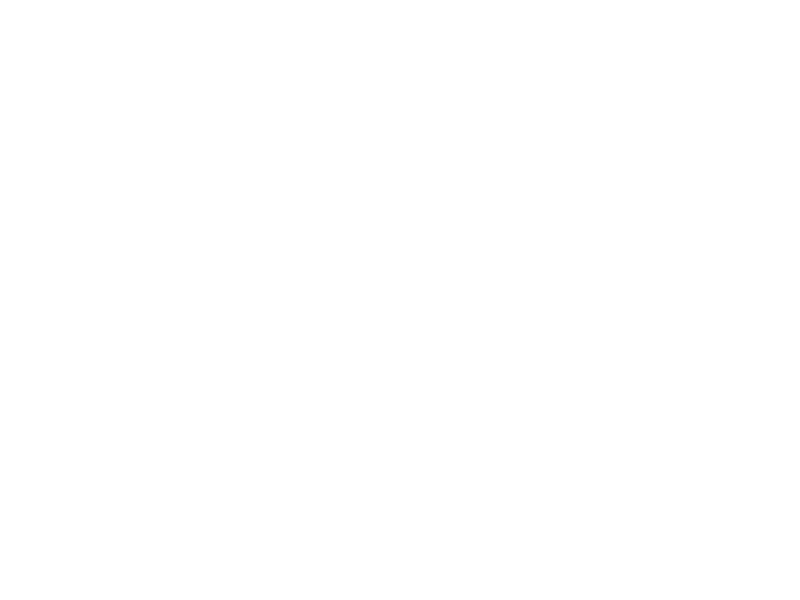

In [18]:
%matplotlib notebook
distortions = []

K = range(1,10,1)

X = final_res[['stars', 'price_rng']]

for k in K:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_, 'euclidean'), axis=1)))
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

business_id        SUhBnQdG8MWkmjM6wsnVdw
similarity                              1
review_count                    0.0123511
stars                                 0.7
price_rng                            0.75
weighted_rating                0.00864579
Name: 7, dtype: object


/home/nirupam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


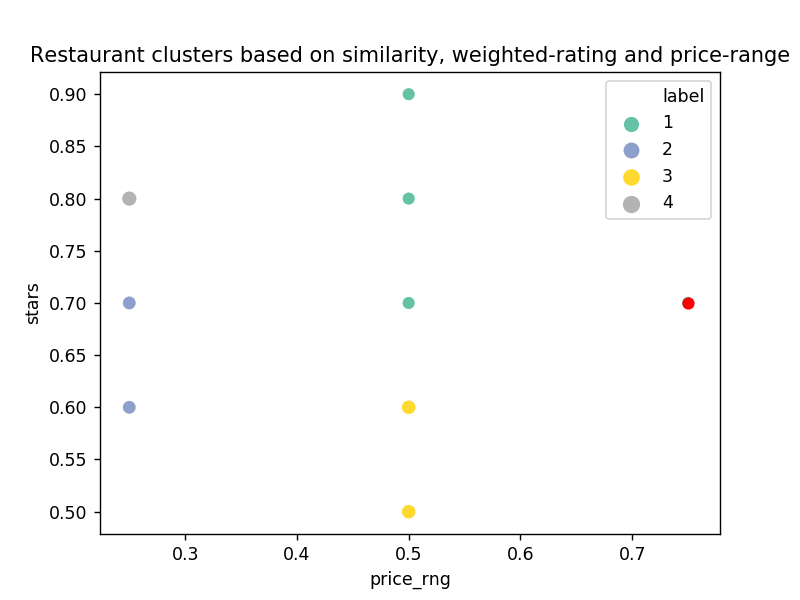

In [19]:
%matplotlib notebook

print(final_res.iloc[0])

X2 = final_res[['price_rng', 'stars']]
final_means = cluster.KMeans(n_clusters = 4)
final_means.fit(X2)

X2['label']= final_means.labels_ + 1
ax = sns.scatterplot(x="price_rng", y="stars", hue="label", size="label", sizes=(60, 80), palette="Set2", 
                legend="full", data=X2)
ax.set_title("Restaurant clusters based on similarity, weighted-rating and price-range")
plt.scatter(x=final_res.iloc[0]['price_rng'], y=final_res.iloc[0]['stars'], color='r')

final_res['label'] = X2['label']

In [20]:
point_label = final_res.iloc[0]['label']

print(final_res['business_id'].head(10))

print(final_res[final_res['label'] == point_label].sort_values(['similarity'])['business_id'].head(10))

7       SUhBnQdG8MWkmjM6wsnVdw
7721    3HrT5IcO3sd4pSBCFP4OYw
2269    fgm7DKVy1wuod6FTPvZqRw
1700    WfgupKdYx1h0mKBmOmNQ3g
6163    tK-PQOhZo94fonbQVXaOSg
9827    xftWto4IdilizsGdE07AQw
8027    Rvj6ryvV1Wf-27UT75soMA
4894    lap6PTY8pyckPSMgvCuIbA
4643    f9ERQpAPOAMv5Ay0kyD3Yw
5616    rgTcICdtCXoNXc71Z7-t5g
Name: business_id, dtype: object
33       fnaDx7UD4MiodQlgYHDwsQ
6167     aY-lZvoTHAFl9k6dcfcAxQ
4982     3G_wGIblXDNRYg4xIe9VZA
5480     jenDHueIvOhpB-0ivdiRoQ
2967     aqbY6f-ZqJ7wnUSll3BxLA
6497     5WhDd9MnacntXYURmvgMZA
5423     0kag5JGemji05P3oxx4lpg
1485     8XNpKETQcSLUPAROULyrOg
11052    3SozmlI5K7xapJBE41Ah1g
8824     DstNnjUe4RpBuKUqLdFzyQ
Name: business_id, dtype: object


#### 10. Check for other restaurants in the list

In [21]:
result.business_id

0        8-NRKkPY1UiFXW20WXKiXg
1        _c3ixq9jYKxhLUB0czi0ug
2        3ByGQOVgds2YEu6kzl-XEQ
3        CeuTRtwsq6w5rztGOyNMPg
4        AcGRSWCpb7YB95MTsHlGEw
5        cKRMmytHxaSt8F0SMEzKqg
6        F73T-N5lRNL2Gcpg0Q4KKw
7        SUhBnQdG8MWkmjM6wsnVdw
8        RcxVK_OEXv3MccIo0nYMZg
9        WUA2Rhlb43HBw9sT2R0wmg
10       rFeJgbnLxtcdqIpBdhpxtQ
11       s2gjJKptpkmwSXYRtfptZQ
12       c3ukNv4GHicrT6K9G2IW3w
13       nGuhjKrZjqvB2xodGo7m7Q
14       maBe6J_QSeYlAa1YNkAyVA
15       8vA1d9_w4hBjOcrM7mNWFg
16       CcTvk2-unBwmAZmU3PlKww
17       sh69ApUyPhAltAMpv5vX3w
18       C4eRHCr7u-cv8B7OaMQKsg
19       bVl0_l6sCwjADKRLGxsXAw
20       ohYgabP6PqkNsF0vnZUxeg
21       0a1aewKFcvPsCQtIrluCmQ
22       UGyEr_PMA-v1cuim0gMPlQ
23       wcNvlrB5xSxzXex2M3UyvQ
24       JQLUWnceJyKuMDqV0HHRUg
25       gG1eunP_GeV8NFCVwrWYmw
26       YGaowC1J4GfkQYyYLYWnQQ
27       h7EShY2aJJYVa35GL_f62Q
28       vFnzV9uy9nEXFQgkSuv_AQ
29       BUcyHikUyo4U12-3RvDKlg
                  ...          
11042   